In [1]:
#Import the libraries
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
import scipy.stats as st
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV 
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import warnings 
%matplotlib inline 

In [2]:
#Read the clean data file and load into the dataframe
df = pd.read_csv('data_clean.csv', parse_dates=['First_Payment_Date', 'Maturity_Date'])
df.head()

,First_Payment_Date,Maturity_Date,Loan_Amount,Zip,Property_Value,Year_Built,Net_Operating_Income,Effective_Gross_Income,Total_Operating_Expenses,Maintenance_Expense,Taxes_Expense,Insurance_Expense,Utilities_Expense,Payroll_Expense,Property_Age
0,2017-06-01,2022-05-01,2143864.02,60077,3003400.24,1965,153643.96,282027.80,125597.78,18793.51,41580.76,9110.30,11233.91,12215.12,52
1,2017-06-01,2037-05-01,1445991.78,33441,1798349.30,1960,105282.69,180649.26,75213.72,14200.86,32705.82,13001.24,0.00,0.00,57
2,2017-06-01,2037-05-01,2725017.88,94597,1653153.29,1959,230180.51,305261.44,71830.08,11574.56,39049.76,3869.46,381.04,0.00,58
3,2017-07-01,2037-06-01,4203448.93,95670,7554077.66,1976,509272.80,890801.66,417618.92,82308.66,51614.93,11441.55,25899.44,104574.43,41
4,2017-06-01,2027-05-01,872183.47,90008,1306139.10,1952,68206.10,101021.26,34641.78,7161.38,11057.87,3008.81,6592.98,0.00,65


In [3]:
warnings.simplefilter('ignore')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 955 entries, 0 to 954
Data columns (total 15 columns):
First_Payment_Date          955 non-null datetime64[ns]
Maturity_Date               955 non-null datetime64[ns]
Loan_Amount                 955 non-null float64
Zip                         955 non-null int64
Property_Value              955 non-null float64
Year_Built                  955 non-null int64
Net_Operating_Income        955 non-null float64
Effective_Gross_Income      955 non-null float64
Total_Operating_Expenses    955 non-null float64
Maintenance_Expense         955 non-null float64
Taxes_Expense               955 non-null float64
Insurance_Expense           955 non-null float64
Utilities_Expense           955 non-null float64
Payroll_Expense             955 non-null float64
Property_Age                955 non-null int64
dtypes: datetime64[ns](2), float64(10), int64(3)
memory usage: 112.0 KB


Traget variable **LoanToValue** is created using the folrmula **Loan_Amount/Property_Value**.

My approach is to first feed all the data to basic **OLS regression model to set the benchmark of model validation score which is R2 and Mean Squared Error.** Once the benchmark score is set, different feature engineering techniques and machine learning regression algorithms can be applied to achieve the best score. I took **80% of data to train and 20% of data to test** the model.

From the ** base model(basic OLS) I got the R2 score as 0.37 and mse is 0.020**

As Heatmap clearly showed multi-collinearity exists between the features, I used ** variance_inflation_factor** to determine the collinearity and **LASSO** for feature selection.

In [5]:
df_loantoVal = df[(df.Loan_Amount != 0) & (df.Property_Value != 0)]
df_loantoVal['LoanToValue'] = (df_loantoVal.Loan_Amount/df_loantoVal.Property_Value)

In [6]:
# Create predictor and target variables as X and y
X= df_loantoVal.drop(['First_Payment_Date' ,'Maturity_Date','LoanToValue'], axis=1)
y = df_loantoVal['LoanToValue']

In [7]:
X.shape, y.shape

((814, 13), (814,))

In [8]:
#Split the data as train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.20, random_state=42) 
X_train.shape , y_train.shape,  X_test.shape, y_test.shape

((651, 13), (651,), (163, 13), (163,))

In [9]:
# OLS regression 
linearReg = LinearRegression()
linearReg.fit(X_train, y_train)
predicted_linear_y = linearReg.predict(X_test)
print("OLS Mean Squared error:",mean_squared_error(y_test, predicted_linear_y ))
print("OLS R2 Score:",linearReg.score(X_test, y_test))

OLS Mean Squared error: 0.0206292596493
OLS R2 Score: 0.372792577192


As Heatmap clearly shows multi-collinearity exists between the features, I used ** variance_inflation_factor** to determine the collinearity and Lasso for feature selection. 

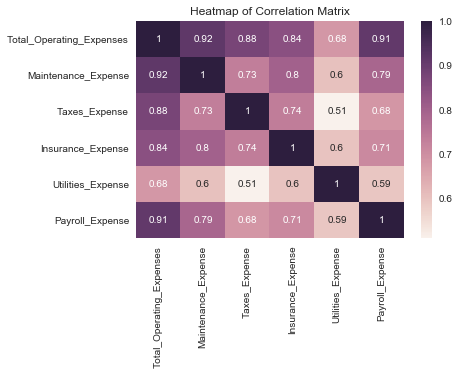

In [10]:
X_expense= pd.DataFrame(df[['Total_Operating_Expenses','Maintenance_Expense','Taxes_Expense',
                            'Insurance_Expense','Utilities_Expense','Payroll_Expense']])
col_corr =X_expense.corr()
sns.heatmap(col_corr, annot=True)
sns.plt.title('Heatmap of Correlation Matrix')

In [11]:
X_expense= pd.DataFrame(df[['Total_Operating_Expenses','Maintenance_Expense','Taxes_Expense',
                            'Insurance_Expense','Utilities_Expense','Payroll_Expense']])
vifT = pd.DataFrame()
vifT["VIF_Factor"] = [variance_inflation_factor(X_expense.values, i) for i in range(X_expense.shape[1])]
vifT["features"] = X_expense.columns
vifT.round(1)

,VIF_Factor,features
0,185.7,Total_Operating_Expenses
1,20.9,Maintenance_Expense
2,21.1,Taxes_Expense
3,6.1,Insurance_Expense
4,3.7,Utilities_Expense
5,25.6,Payroll_Expense


In [12]:
# Instantiate a lasso regressor: lasso
lasso = Lasso()
# Fit the regressor to the data
lasso.fit(X_train, y_train)
predicted_lasso = lasso.predict(X_test)
print("Lasso Mean Squared error:",mean_squared_error(y_test, predicted_lasso))
print("Lasso R2 Score:",lasso.score(X_test, y_test))

Lasso Mean Squared error: 0.0205385087854
Lasso R2 Score: 0.375551746278


In [13]:
#The coefficients
pd.DataFrame({'features': X.columns, 'LasoCoefficients': lasso.coef_})

,LasoCoefficients,features
0,2.959103e-08,Loan_Amount
1,-1.088985e-06,Zip
2,-1.360779e-08,Property_Value
3,0.000000e+00,Year_Built
4,-7.400854e-08,Net_Operating_Income
5,-1.379409e-08,Effective_Gross_Income
6,2.275078e-08,Total_Operating_Expenses
7,-2.913718e-07,Maintenance_Expense
8,-7.828527e-08,Taxes_Expense
9,-2.919159e-07,Insurance_Expense


In [14]:
X1 = pd.DataFrame(X[['Loan_Amount','Property_Value']])

In [15]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y, test_size=.20, random_state=42) 
X1_train.shape , y1_train.shape,  X1_test.shape, y1_test.shape

((651, 2), (651,), (163, 2), (163,))

In [16]:
# Instantiate a lasso regressor: lasso
lasso = Lasso()
# Fit the regressor to the data
lasso.fit(X1_train, y1_train)
predicted_lasso_y = lasso.predict(X1_test)
print("Lasso Mean Squared error:",mean_squared_error(y1_test, predicted_lasso_y))
print("Lasso R2 Score:",lasso.score(X1_test, y1_test))

Lasso Mean Squared error: 0.0214919726193
Lasso R2 Score: 0.346562843906


In [17]:
# Instantiate a Ridge regressor
ridg = Ridge()
# Fit the regressor to the data
ridg.fit(X_train, y_train)
predicted_ridg_y = ridg.predict(X_test)
print("Ridge Mean Squared error:",mean_squared_error(y_test, predicted_ridg_y))
print("Ridge R2 Score:",ridg.score(X_test, y_test))

Ridge Mean Squared error: 0.0206292595069
Ridge R2 Score: 0.372792581523


As I suspected, since **predictor variables are highly correlated** OLS models after applying L1 regularization(LASSO) or R2 regularization(Ridge) is not able to achieve the desired R2 score which was .37.

**RandomForestRegressor** Model worked here with** R2 score 0.59**. I further tuned this using **RandomizedSearchCV and GridSearchCV** which improvised the **model R2 score to .73 and mse to 0.00 **

I used** 3 fold cross validation** to validate the model.


In [18]:
#Instantiate a Randomorest regressor: rfreg
rfreg = RandomForestRegressor(random_state=42)
rfreg.fit(X_train, y_train)
rfreg.score(X_test, y_test)

0.59463758313459469

In [19]:
# Parameter tuning with RandomizedSearchCV
param_dist2 = {"n_estimators": [20,50,100],
              "max_depth": [1,5,10,25, None],
              "criterion": ["mse", "mae"],
              "max_features":['auto', "sqrt"],
              "max_leaf_nodes":[2,5,10,None],
              "min_samples_leaf":[1,5,10,25],
              "random_state":[42]}

# Instantiate a Decision Tree classifier: tree
RDtree = RandomForestRegressor()

# Instantiate the RandomizedSearchCV object: tree_cv
RDtree_cv = RandomizedSearchCV (RDtree, param_dist2, cv=5)

# Fit it onto the data
RDtree_cv.fit(X_train, y_train)

# Print the tuned parameters and score
print("Tuned Decision Tree Parameters: {}".format(RDtree_cv.best_params_))
print("Best score is {}".format(RDtree_cv.best_score_))

Tuned Decision Tree Parameters: {'random_state': 42, 'n_estimators': 20, 'min_samples_leaf': 5, 'max_leaf_nodes': None, 'max_features': 'auto', 'max_depth': 5, 'criterion': 'mse'}
Best score is 0.6502432723815043


In [20]:
# Parameter tuning with GridSearchCV
param_dist2 = {"n_estimators": [100],
              "max_depth": [10,25 ],
              "max_features":["sqrt","auto" ],
              "min_samples_leaf":[1,5],
              "random_state":[42]}

# Instantiate a Decision Tree classifier: tree
RDtree = RandomForestRegressor()

# Instantiate the RandomizedSearchCV object: tree_cv

RDtree_cv = GridSearchCV(RDtree, param_dist2, cv=5)
# Fit it to the data
RDtree_cv.fit(X_train, y_train)

# Print the tuned parameters and score
print("Tuned Decision Tree Parameters: {}".format(RDtree_cv.best_params_))
print("Best score is {}".format(RDtree_cv.best_score_))

Tuned Decision Tree Parameters: {'max_depth': 25, 'max_features': 'auto', 'min_samples_leaf': 1, 'n_estimators': 100, 'random_state': 42}
Best score is 0.7643890864187429


In [21]:
#Initiate RandomForestRegressor with tuned parameters
RandomForestReg= RandomForestRegressor(max_depth= 25, min_samples_leaf= 1, n_estimators= 100,  random_state=42)

In [22]:
# 3 fold cross validation 
RandomForestReg.fit(X_train, y_train)
RandomForestReg_score = cross_val_score(RandomForestReg , X_train, y_train, cv=3, scoring='r2').mean()
RandomForestReg_mse = cross_val_score(RandomForestReg , X_train, y_train, cv=3, scoring='neg_mean_squared_error').mean()
print("RandomForestRegressor R2 ScoreR2 Score:",RandomForestReg_score)
print("RandomForestRegressor mean squared error:",RandomForestReg_mse)

RandomForestRegressor R2 ScoreR2 Score: 0.734982655973
RandomForestRegressor mean squared error: -0.00805882588139


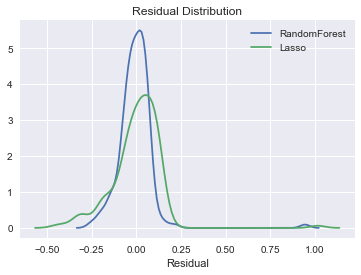

In [23]:
# Residual plot for RandomForest and Lasso
pred_reg = RandomForestReg.predict(X_test)
resd_RF = y_test-pred_reg # Residual of RandomForestRegressor
resd_Lasso =y_test - predicted_lasso # Residual of Lasso
sns.kdeplot(resd_RF, label='RandomForest')
sns.kdeplot(resd_Lasso, label='Lasso')
plt.title("Residual Distribution")
plt.xlabel('Residual')

I would recommend using **tuned RandomForestRegressor** for the prediction of Loan to Value here. Accuracy of this model can further be improvised  by **treating the outliers**. Presence of outlier values in the training data affects the model accuracy. It leads to inaccurate predictions. This is because we don’t analyse the behavior and relationship with other variables correctly. So, treating the outliers can improvise the model accuracy.

We can also **tune the hyperparameter** further for more accuracy.